In [1]:
import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
#from catboost import Pool, CatBoostClassifier

from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations
from statsmodels.stats.proportion import proportion_confint


In [2]:
data = pd.read_csv(
    '/Users/reejungkim/Documents/Git/loan_data_2007_2014.csv',
    parse_dates=['issue_d'], infer_datetime_format=True)

#data = data[(data.issue_d >= '2018-01-01 00:00:00') & (data.issue_d < '2019-01-01 00:00:00')]
data = data.reset_index(drop=True)
data.head()

/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.shape

(466285, 74)

In [4]:
data.columns
#data.info()

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

data.describe().transpose()

In [5]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing.round(2)})
missing_value_df.sort_values('percent_missing', inplace=True)

In [6]:
missing_value_df

,column_name,percent_missing
id,id,0.0
zip_code,zip_code,0.0
addr_state,addr_state,0.0
dti,dti,0.0
revol_bal,revol_bal,0.0
...,...,...
open_acc_6m,open_acc_6m,100.0
total_cu_tl,total_cu_tl,100.0
verification_status_joint,verification_status_joint,100.0
total_bal_il,total_bal_il,100.0


In [7]:
(missing_value_df['percent_missing'] == 100.00).sum()

17

In [8]:
# List of columns having NULL values
missing_value_df[(missing_value_df['percent_missing'] == 100.00)].column_name.tolist()

['dti_joint',
 'inq_fi',
 'all_util',
 'max_bal_bc',
 'open_rv_24m',
 'open_rv_12m',
 'il_util',
 'mths_since_rcnt_il',
 'annual_inc_joint',
 'open_il_24m',
 'open_il_12m',
 'open_il_6m',
 'open_acc_6m',
 'total_cu_tl',
 'verification_status_joint',
 'total_bal_il',
 'inq_last_12m']

#Dropping columns having all missing values
null_columns_dropped_data = data.drop(missing_values_columns, axis=1)

In [9]:
(missing_value_df['percent_missing'] >= 50.00).sum()

21

In [10]:
column_list_to_drop = missing_value_df[(missing_value_df['percent_missing'] >= 50.00)].column_name.tolist()

In [11]:
data = data.drop(column_list_to_drop, axis=1)

In [12]:
data.shape

(466285, 53)

In [13]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,171.62,NaN,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,119.66,NaN,Sep-13,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,649.91,NaN,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,357.48,NaN,Jan-15,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,67.79,Feb-16,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN


In [14]:
data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'],
      dtype='object')

In [15]:
count_unique = []
for row in data.columns.tolist():
    count_unique.append({'column': row, 'count': len(data[row].unique())})

In [16]:
pd.DataFrame(count_unique).sort_values('count')

,column,count
48,application_type,1
47,policy_code,1
5,term,2
17,pymnt_plan,2
32,initial_list_status,2
14,verification_status,3
12,home_ownership,6
49,acc_now_delinq,7
8,grade,7
16,loan_status,9


In [17]:
#data.loan_status.unique()
data.loan_status.value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

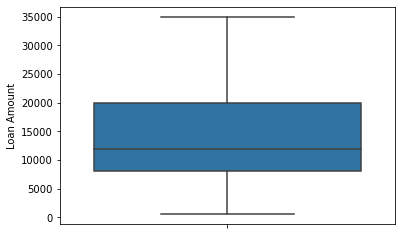

In [18]:
sns.boxplot( y=data["loan_amnt"] )
plt.ylabel('Loan Amount')
plt.show()

<module 'matplotlib.pyplot' from '/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/matplotlib/pyplot.py'>

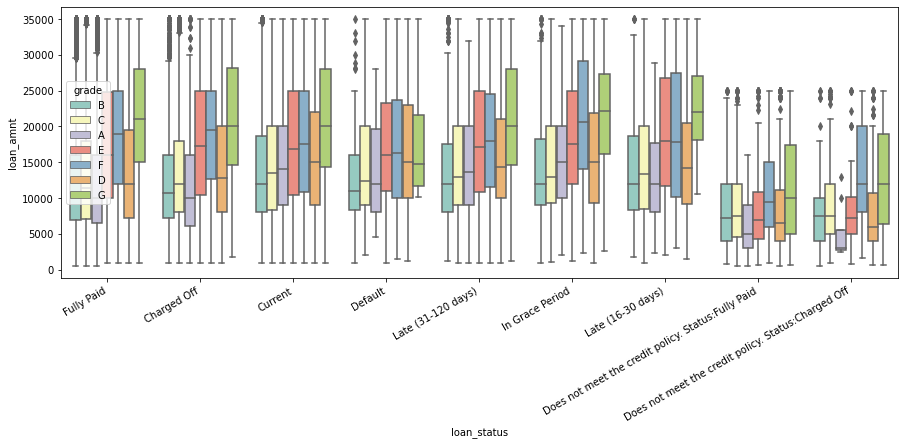

In [19]:

plt.figure(figsize=(15,5))

sns.boxplot(x="loan_status", y="loan_amnt",  hue="grade",
                 data=data, palette="Set3")

#plt.xticks(rotation=45)
plt.setp(plt.xticks()[1], rotation=30, ha='right') #ha = horizonalalignment
plt

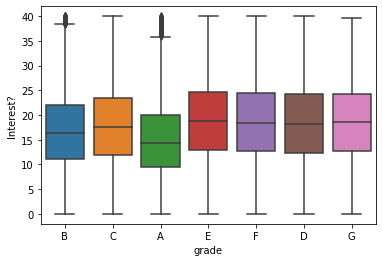

In [20]:
sns.boxplot(y='dti', x='grade', data=data)
plt.ylabel('Interest?')
plt.show()

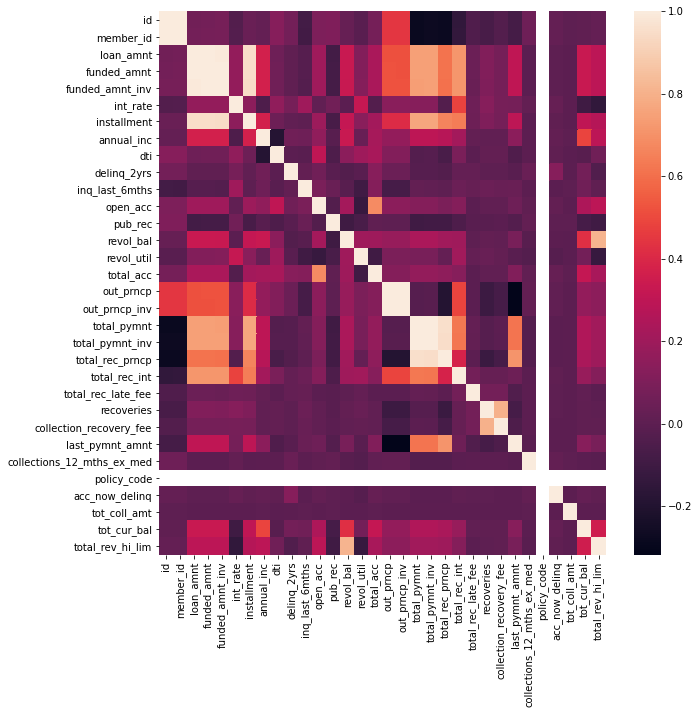

In [21]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr())
plt.show()